In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**LOADING MY FILE**

In [3]:
# opening the input files
file = open('/content/drive/MyDrive/NLP- Assignments/spa-eng.txt', mode='r', encoding='utf-8')
        
# reading all text
text = file.read()

# closing the file
file.close()

*SPLITTING INTO TEXT**


In [5]:
# split using '\n' or newline character
sentences = text.strip().split('\n')
    
# split between english and spanish
spanish_english = [i.split('\t')[:2] for i in sentences]

# list to numpy array
spanish_english = np.array(spanish_english)

print(spanish_english)

[['Go.' 'Ve.']
 ['Go.' 'Vete.']
 ['Go.' 'Vaya.']
 ...
 ['A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.'
  'Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque están preocupados acerca del cambio climático.']
 ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.'
  'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y esper

**DATA CLEANING**


In [6]:
# function to clean punctuations from text
def clean(sentence):
  punc = '''!()-[]{};:'", <>./?@#$%^&*_~'''
  for i in range(len(sentence)):  
        if sentence[i] in punc:  
            sentence =sentence.replace(sentence[i], " ")  
  return sentence

for i in range(len(spanish_english)):
  spanish_english[i,0]=clean(spanish_english[i,0])
  spanish_english[i,1]=clean(spanish_english[i,1])

In [7]:
# transforming all uppercase character to lowercase to remove case sensitivity
for i in range(len(spanish_english)):
    spanish_english[i,0] = spanish_english[i,0].lower()
    spanish_english[i,1] = spanish_english[i,1].lower()

In [8]:
# for English side data
# initialising tokenizer
eng_tokenizer = Tokenizer()
# fitting data
eng_tokenizer.fit_on_texts(spanish_english[:,0])
# getting vocab size
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# for English side data
# initialising tokenizer
spanish_tokenizer = Tokenizer()
# fitting data
spanish_tokenizer.fit_on_texts(spanish_english[:,1])
# getting vocab size
spanish_vocab_size = len(spanish_tokenizer.word_index) + 1

spanish_length = 8
print('Spanish Vocabulary Size: %d' % spanish_vocab_size)

English Vocabulary Size: 13302
Spanish Vocabulary Size: 27505


In [9]:
#splitting dataset into train set 
from sklearn.model_selection import train_test_split

# split data into train and test set in 80:20 ratio
train, test = train_test_split(spanish_english, test_size=0.2, random_state = 12)

**TOKENS TO SEQUENCE**

In [10]:
# function to encode text into numbers
def encode_sequences( tokenizer , length , lines):

  seq = tokenizer.texts_to_sequences(lines)
  
  # pad sequences with 0 values to make all sequences of equal length
  seq = pad_sequences(seq, maxlen=length, padding='post')

  return seq

In [11]:
# prepare training data
# spanish part
trainX = encode_sequences(spanish_tokenizer, spanish_length, train[:, 1])

# english part
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
# spanish part
testX = encode_sequences(spanish_tokenizer, spanish_length, test[:, 1])

# english part
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

**MODELLING**

In [12]:
#DEFINING MODEL
# model initialisation
model = Sequential()

# adding embedding layer
model.add(Embedding(spanish_vocab_size, 256, input_length=spanish_length, mask_zero=True))

# adding a LSTM layer
model.add(LSTM(256))

model.add(RepeatVector(eng_length))

# adding a LSTM layer
model.add(LSTM(256, return_sequences=True))

# adding a dense layer to predict words in english
model.add(Dense(eng_vocab_size, activation='softmax'))

# view model details
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 256)            7041280   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 256)            525312    
_________________________________________________________________
dense (Dense)                (None, 8, 13302)          3418614   
Total params: 11,510,518
Trainable params: 11,510,518
Non-trainable params: 0
_________________________________________________________________


In [13]:
#COMPILING MODEL!

# using adam optimizer with sparse categorical cross entropy as loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Training Model

In [16]:
# path to save model
filename = '/content/drive/MyDrive/NLP- Assignments'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=200, validation_split = 0.7,callbacks=[checkpoint], verbose=1)

Epoch 1/10
151/151 [==============================] - 290s 2s/step - loss: 4.6668 - val_loss: 4.6704

Epoch 00001: val_loss improved from inf to 4.67036, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 2/10
151/151 [==============================] - 293s 2s/step - loss: 4.6082 - val_loss: 4.6420

Epoch 00002: val_loss improved from 4.67036 to 4.64202, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 3/10
151/151 [==============================] - 292s 2s/step - loss: 4.5673 - val_loss: 4.6245

Epoch 00003: val_loss improved from 4.64202 to 4.62455, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 4/10
151/151 [==============================] - 294s 2s/step - loss: 4.5221 - val_loss: 4.6000

Epoch 00004: val_loss improved from 4.62455 to 4.59998, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 5/10
151/151 [==============================] - 289s 2s/step - loss: 4.4719 - val_loss: 4.5656

Epoch 00005: val_loss improved from 4.59998 to 4.56565, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 6/10
151/151 [==============================] - 292s 2s/step - loss: 4.4125 - val_loss: 4.5121

Epoch 00006: val_loss improved from 4.56565 to 4.51208, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 7/10
151/151 [==============================] - 293s 2s/step - loss: 4.3406 - val_loss: 4.4613

Epoch 00007: val_loss improved from 4.51208 to 4.46133, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 8/10
151/151 [==============================] - 299s 2s/step - loss: 4.2757 - val_loss: 4.4386

Epoch 00008: val_loss improved from 4.46133 to 4.43858, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 9/10
151/151 [==============================] - 295s 2s/step - loss: 4.2212 - val_loss: 4.4048

Epoch 00009: val_loss improved from 4.43858 to 4.40481, saving model to /content/drive/MyDrive/NLP- Assignments


Epoch 10/10
151/151 [==============================] - 294s 2s/step - loss: 4.1661 - val_loss: 4.3779

Epoch 00010: val_loss improved from 4.40481 to 4.37790, saving model to /content/drive/MyDrive/NLP- Assignments


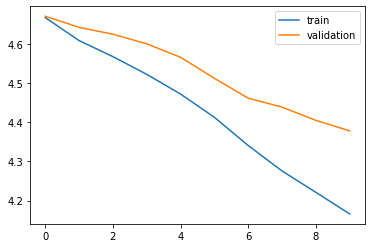

In [17]:
 #viewing model training progress 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [41]:
# load trained model
model = load_model('/content/drive/MyDrive/NLP- Assignments/OLD-SPA')

# list to store predictions
preds_list=[]

# predicting for 500 test sentences
for i in range(500):
  # predict function return the probabilities for target vobabularies
  # argmax return the index having the maximum value
  preds_list.append(np.argmax(model.predict(testX[i]), axis=-1))

In [42]:
# function to map numbers to word in english language
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [43]:
# to store predicted texts
preds_text = []

# to traverse predicted values
for preds in preds_list:

  # to store predicted sentence
  sentence=''

  # iterating through each sequence
  for i in preds:
        # to store words 
        temp = []
        for j in range(len(i)):
              t = get_word(i[j], eng_tokenizer)
              if j > 0:
                  if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                      temp.append('')
                  else:
                      temp.append(t)
              else:
                    if(t == None):
                            temp.append('')
                    else:
                            temp.append(t)
        # forming by combining words
        sentence=sentence+' '+str.strip(' '.join(temp))
        
  # adding predicted sentences to list
  preds_text.append(sentence)

In [44]:
# viewing predictions
pred_df = pd.DataFrame({'actual' : test[:500,0], 'predicted' : preds_text[:500]})
pred_df.sample(10)

,actual,predicted
405,would you like to add me to your contact list,i you tom tom i it you tom tom tom
256,what color do you like,let you tom let you let tom tom tom tom tom
135,i know what s going on,i you let it i you tom let it tom tom tom
482,he listened very carefully in order not to miss a single word,i you i tom i it let you the you i it
15,that s an incredible story,they is the tom tom tom tom tom tom
420,i ve been here the longest,i it i you i it you i you tom tom tom
311,i know tom from work,i you tom tom the i you tom tom tom
484,do you like to be alone,i you let tom let to i you tom tom tom tom
198,tom is my father,tom they is i the tom tom tom tom tom
451,i know the feeling,i you let it i you tom tom tom tom tom


In [45]:
import nltk

BLEU = 0

for i in range(500):
  BLEU += nltk.translate.bleu_score.sentence_bleu([test[i,0]], preds_text[i])

BLEU/=500

print("BLEU Score achieved is :",BLEU*100)

BLEU Score achieved is : 20.916028194831817


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


TRAINING MODEL WITH LITTLE CHANGES

In [31]:
# path to save model
filename = '/content/drive/MyDrive/NLP- Assignments/spa-english'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=250, validation_split = 0.3,callbacks=[checkpoint], verbose=1)

Epoch 1/5
281/281 [==============================] - 393s 1s/step - loss: 1.5979 - val_loss: 2.9193

Epoch 00001: val_loss improved from inf to 2.91933, saving model to /content/drive/MyDrive/NLP- Assignments/spa-english


Epoch 2/5
281/281 [==============================] - 397s 1s/step - loss: 1.5177 - val_loss: 2.9294

Epoch 00002: val_loss did not improve from 2.91933
Epoch 3/5
281/281 [==============================] - 392s 1s/step - loss: 1.4429 - val_loss: 2.9172

Epoch 00003: val_loss improved from 2.91933 to 2.91724, saving model to /content/drive/MyDrive/NLP- Assignments/spa-english


Epoch 4/5
281/281 [==============================] - 396s 1s/step - loss: 1.3755 - val_loss: 2.9274

Epoch 00004: val_loss did not improve from 2.91724
Epoch 5/5
281/281 [==============================] - 395s 1s/step - loss: 1.3116 - val_loss: 2.9355

Epoch 00005: val_loss did not improve from 2.91724


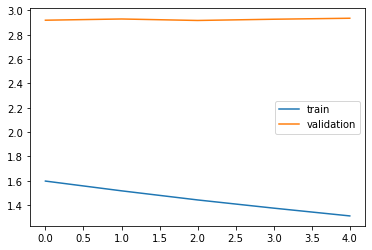

In [32]:
# viewing model training progress 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [36]:
# load trained model
model = load_model('/content/drive/MyDrive/NLP- Assignments/spa-english')

# list to store predictions
preds_list=[]

# predicting for 500 test sentences
for i in range(500):
  # predict function return the probabilities for target vobabularies
  # argmax return the index having the maximum value
  preds_list.append(np.argmax(model.predict(testX[i]), axis=-1))

In [37]:
# function to map numbers to word in english language
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [38]:
# to store predicted texts
preds_text = []

# to traverse predicted values
for preds in preds_list:

  # to store predicted sentence
  sentence=''

  # iterating through each sequence
  for i in preds:
        # to store words 
        temp = []
        for j in range(len(i)):
              t = get_word(i[j], eng_tokenizer)
              if j > 0:
                  if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                      temp.append('')
                  else:
                      temp.append(t)
              else:
                    if(t == None):
                            temp.append('')
                    else:
                            temp.append(t)
        # forming by combining words
        sentence=sentence+' '+str.strip(' '.join(temp))
        
  # adding predicted sentences to list
  preds_text.append(sentence)

In [39]:
# viewing predictions
pred_df = pd.DataFrame({'actual' : test[:500,0], 'predicted' : preds_text[:500]})
pred_df.sample(15)

,actual,predicted
358,can it be fixed,do you it loosen it it fix
243,there is a bathroom here,let s there take a here
333,i don t have the slightest idea what to do,it wouldn i have leave the thanks just bad tom let what it push it
97,have my kids been annoying you,do you like they i s up champagne i my come children
199,the mail has arrived,it it the get up mail
308,i can t play the flute,it wouldn i know play to leave the stay
207,tom took little sips of the piping hot coffee,examine tom it s up look a close the get the coffee make very good be warm
269,i don t know anybody here,here it wouldn i know them go nobody anyone
299,shampoo and toothpaste are the same price,the i and the a of it push it the
136,i ran in order to be on time,i ran go let it go just it time


In [40]:
import nltk

BLEU = 0

for i in range(500):
  BLEU += nltk.translate.bleu_score.sentence_bleu([test[i,0]], preds_text[i])

BLEU/=500

print("BLEU Score achieved is :",BLEU*100)

BLEU Score achieved is : 29.60729675786744


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
